In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from AlzheimerCNN import AlzheimerCNN

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='D:\\Projetos\\AlzheimerEarlyDetection_v4\\datasets\\train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='D:\\Projetos\\AlzheimerEarlyDetection_v4\\datasets\\test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_to_idx = train_dataset.class_to_idx  # Dicionário mapeando classe -> índice

print("Mapeamento de Classes:")
for class_name, class_index in class_to_idx.items():
    print(f"{class_index}: {class_name}")

Mapeamento de Classes:
0: Mild Impairment
1: Moderate Impairment
2: No Impairment
3: Very Mild Impairment


In [11]:
model = AlzheimerCNN(num_classes=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()

        running_loss += loss.item()

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)  # Pega a classe com maior probabilidade
        total += labels.size(0)  # Número total de amostras
        correct += (predicted == labels).sum().item()  # Contagem de previsões corretas

    # Calcula a média da perda e a acurácia da época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")



Epoch [1/100], Loss: 1.2138, Accuracy: 41.40%
Epoch [2/100], Loss: 0.7648, Accuracy: 64.10%
Epoch [3/100], Loss: 0.6741, Accuracy: 68.99%
Epoch [4/100], Loss: 0.6335, Accuracy: 71.36%
Epoch [5/100], Loss: 0.6001, Accuracy: 72.68%
Epoch [6/100], Loss: 0.5819, Accuracy: 73.73%
Epoch [7/100], Loss: 0.5651, Accuracy: 74.14%
Epoch [8/100], Loss: 0.5393, Accuracy: 75.81%
Epoch [9/100], Loss: 0.5247, Accuracy: 76.58%
Epoch [10/100], Loss: 0.5052, Accuracy: 77.53%
Epoch [11/100], Loss: 0.4941, Accuracy: 77.87%
Epoch [12/100], Loss: 0.4933, Accuracy: 77.64%
Epoch [13/100], Loss: 0.4808, Accuracy: 78.55%
Epoch [14/100], Loss: 0.4745, Accuracy: 78.57%
Epoch [15/100], Loss: 0.4613, Accuracy: 79.36%
Epoch [16/100], Loss: 0.4499, Accuracy: 79.73%
Epoch [17/100], Loss: 0.4492, Accuracy: 79.84%
Epoch [18/100], Loss: 0.4453, Accuracy: 80.09%
Epoch [19/100], Loss: 0.4395, Accuracy: 80.53%
Epoch [20/100], Loss: 0.4265, Accuracy: 80.96%
Epoch [21/100], Loss: 0.4170, Accuracy: 81.48%
Epoch [22/100], Loss: 

In [13]:
from sklearn.metrics import accuracy_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

accuracy = accuracy_score(all_labels, all_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")

                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.92      0.95       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.94      0.95      0.94       640
Very Mild Impairment       0.91      0.92      0.91       448

            accuracy                           0.93      1279
           macro avg       0.96      0.95      0.95      1279
        weighted avg       0.93      0.93      0.93      1279

Accuracy: 93.28%


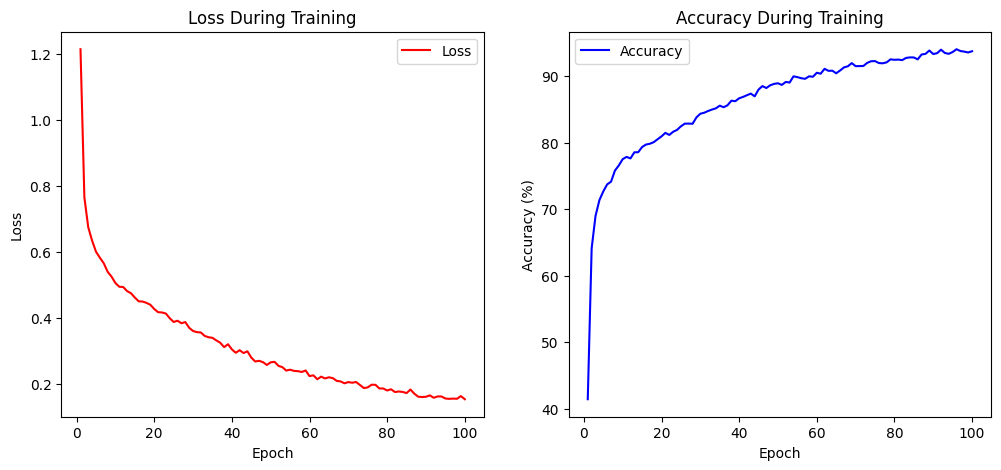

In [14]:
# Plotando o gráfico de perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()

# Plotando o gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy During Training")
plt.legend()

plt.show()


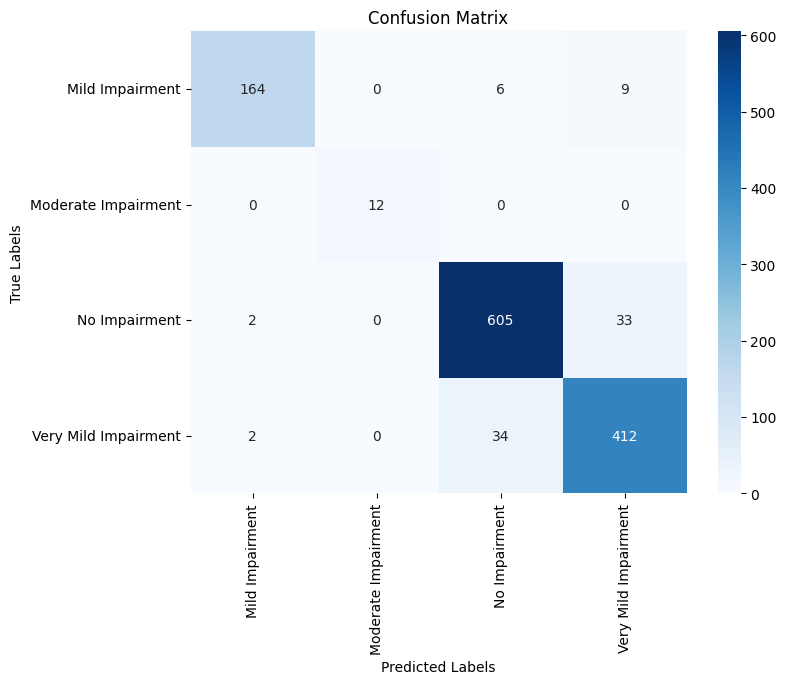

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

class_names = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
torch.save({"model_state": model.state_dict(), "class_to_idx": class_to_idx}, 'alzheimer_mri_model.pth')